In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, "../src/")
sys.path.insert(0, "../projects/skimpy_bench/src/")
sys.path.insert(0, "../projects/skimpy_blox/")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import math
import functools
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

import skimpy
import _skimpy_cpp_ext
import _skimpy_bench_cpp_ext
from skimpy import config as skimpy_config
from skimpy_bench import benchmarks
from skimpy_blox.minecraft import SkimpyMinecraftLevel

sns.set()

In [19]:
NUM_REPEATS = 1
BYTES_PER_INT = 4
MEGABYTES = 1024 * 1024

def log_2_elements_space(start_size_bytes, end_size_bytes, num):
    return np.logspace(math.log2(start_size_bytes // BYTES_PER_INT), math.log2(end_size_bytes // BYTES_PER_INT), base=2, num=num).astype(int)

def line_plot(
    xs,
    ys_dict,
    xlabel=None,
    ylabel=None,
    title=None,
    output_path=None,
):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for legend_name, v_dict in ys_dict.items():
        ax.plot(xs, v_dict["vals"], label=legend_name)
        
    if title:
        plt.title(title)
    if ylabel:
        plt.ylabel(ylabel)
    if xlabel:
        plt.xlabel(xlabel)
    #plt.xscale("log")
    plt.yscale("log")
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: f"{x:.1f}" if x < 1 else f"{x:.0f}"))
    #ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend()
    
    if output_path:
        plt.tight_layout()
        plt.savefig(output_path, dpi=300)
    plt.show()

In [6]:
array_lengths = log_2_elements_space(256, 1000 * MEGABYTES, num=10)
vals = benchmarks.DenseArrayBenchmark.run_against_axis(
    'array_length', array_lengths,
    repeats=NUM_REPEATS,
    num_inputs=4,
)

In [25]:
array_lengths = log_2_elements_space(256, 1000 * MEGABYTES, num=10)
vals = benchmarks.DenseArrayBenchmark.run_suite_axis(
    'array_length', array_lengths,
    repeats=NUM_REPEATS,
    num_inputs=4,
    suite={
        "Skimpy (single-threaded)": {
            "method": "run_skimpy",
            "kwargs": {
                "num_threads": 1
            },
        },
        "Skimpy (multi-threaded)": {
            "method": "run_skimpy",
            "kwargs": {
                "num_threads": 32
            },
        },
        "Taco": {
            "method": "run_taco",
        },
        "Torch": {
            "method": "run_torch",
        },
        "Numpy": {
            "method": "run_numpy"
        },
        "Memory": {
            "method": "run_memory",
        },
    }
)

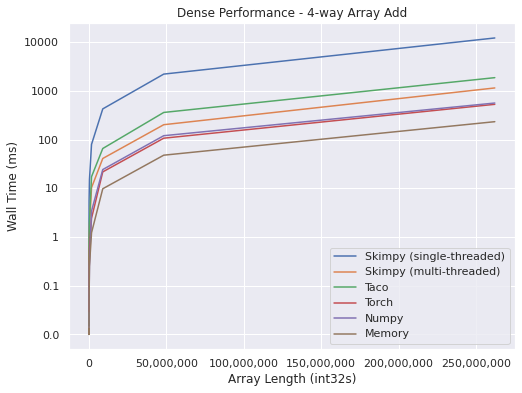

In [26]:
line_plot(
    array_lengths, 
    vals, 
    xlabel="Array Length (int32s)", 
    ylabel="Wall Time (ms)",
    title="Dense Performance - 4-way Array Add"
)

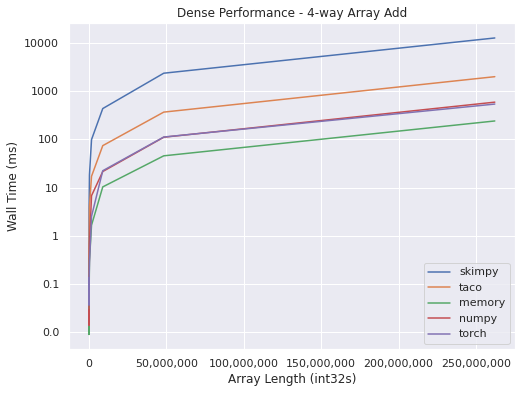